# 인공신경망 모델의 학습

## 학습데이터 불러오기

In [20]:
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [21]:
config_info = {
    'data_folder': './',
    'data_folder_raw': 'E:/',
    'result_file': 'result.csv',
}

In [22]:
def format_data_x(datafile):
    x_data = None
    for item in datafile:
        item_data = np.loadtxt(item, dtype=np.float)
        if x_data is None:
            x_data = np.zeros((len(item_data), 1))
        x_data = np.hstack((x_data, item_data))
    x_data = x_data[:, 1:]
    X = None
    for i in range(len(x_data)):
        row = np.asarray(x_data[i, :])
        row = row.reshape(9, 128).T
        if X is None:
            X = np.zeros((len(x_data), 128, 9))
        X[i] = row
    return X

In [23]:
# This is for parsing the Y data, you can ignore it if you do not need preprocessing
def format_data_y(datafile):
    data = np.loadtxt(datafile, dtype=np.int) - 1
    YY = np.eye(6)[data]
    return YY

In [24]:
# Load data function, if there exists parsed data file, then use it
# If not, parse the original dataset from scratch
def load_data():
    import os
    if os.path.isfile(config_info['data_folder'] + 'data_har.npz') == True:
        data = np.load(config_info['data_folder'] + 'data_har.npz')
        X_train = data['X_train']
        Y_train = data['Y_train']
        X_test = data['X_test']
        Y_test = data['Y_test']
        print(X_train.shape)
        print(X_test.shape)
        print(Y_train.shape)
        print(Y_test.shape)
        
    else:
        # This for processing the dataset from scratch
        # After downloading the dataset, put it to somewhere that str_folder can find
        str_folder = config_info['data_folder_raw'] + 'UCI HAR Dataset/'
        INPUT_SIGNAL_TYPES = [
            "body_acc_x_",
            "body_acc_y_",
            "body_acc_z_",
            "body_gyro_x_",
            "body_gyro_y_",
            "body_gyro_z_",
            "total_acc_x_",
            "total_acc_y_",
            "total_acc_z_"
        ]
        print(str_folder)
        str_train_files = [str_folder + 'train/' + 'Inertial Signals/' + item + 'train.txt' for item in
                           INPUT_SIGNAL_TYPES]
        str_test_files = [str_folder + 'test/' + 'Inertial Signals/' +
                          item + 'test.txt' for item in INPUT_SIGNAL_TYPES]
        str_train_y = str_folder + 'train/y_train.txt'
        str_test_y = str_folder + 'test/y_test.txt'

        X_train = format_data_x(str_train_files)
        X_test = format_data_x(str_test_files)
        Y_train = format_data_y(str_train_y)
        Y_test = format_data_y(str_test_y)
        print(X_train.shape)
        print(X_test.shape)
        print(Y_train.shape)
        print(Y_test.shape)
        
    # npz파일 생성용 !주의 없을때 한번만 실행기키고 바로 주석처리
    #return X_train, Y_train, X_test, Y_test
    return X_train, onehot_to_label(Y_train), X_test, onehot_to_label(Y_test)

In [25]:
def onehot_to_label(y_onehot):
    a = np.argwhere(y_onehot == 1)
    return a[:, -1]

In [26]:
class data_loader(Dataset):
    def __init__(self, samples, labels, t):
        self.samples = samples
        self.labels = labels
        self.T = t

    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.T:
            return self.T(sample), target
        else:
            return sample, target

    def __len__(self):
        return len(self.samples)

In [27]:
def load(batch_size):
    x_train, y_train, x_test, y_test = load_data()
    # npz파일 생성용 !주의 없을때 한번만 실행기키고 바로 주석처리
    #np.savez('E:/연구실/04.신생아 동작인식/data_har.npz', X_train=x_train, Y_train=y_train, X_test=x_test, Y_test=y_test)
    x_train, x_test = x_train.reshape(
        (-1, 128, 9)), x_test.reshape((-1, 128, 9))
    
    print(x_train.shape)
    print(x_test.shape)
    print(y_train.shape)
    print(y_test.shape)

    transform = None
    train_set = data_loader(x_train, y_train, transform)
    test_set = data_loader(x_test, y_test, transform)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

## 필요한 라이브러리 불러오기

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.optim import lr_scheduler

## 모델, 손실 함수, 최적화 함수 설정

In [34]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(RNN, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)
                
    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:,-1])
        out = F.softmax(x, dim=1)
        return out

## 하이퍼파라미터

In [42]:
epoch = 1000
batch_size = 919
lr = 0.001

#seq_length=128
data_dim = 9
hidden_dim = 512
output_dim = 6
layers = 1

#momemtum =0.9

In [43]:
train_loader, test_loader = load(batch_size=batch_size)

(7352, 128, 9)
(2947, 128, 9)
(7352, 6)
(2947, 6)
(7352, 128, 9)
(2947, 128, 9)
(7352,)
(2947,)


In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = RNN(data_dim, hidden_dim, output_dim, layers).to(device)

#loss_func =torch.nn.MSELoss()
loss_func = nn.CrossEntropyLoss()

#optimizer = optim.SGD(params=model.parameters(), lr=lr, momentum=momemtum)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, threshold=1, patience=1, mode='min')

cuda:0


## 모델의 학습

1. RNN은 히든스테이트가 많아서 그런지 잘안됨
2. LSTM과 GrU가능
3. LSTM은 레이어를 쌓아도 큰차이를 보이지 않음
4. GRU는 레이어가 작을때 잘작동
5. 히든스테이트는 많을수록 성능이 좋음


In [45]:
torch.manual_seed(0)

loss_array = []
result_array = []
n_batch = len(train_loader.dataset) // batch_size

for i in range(epoch):
    model.train()
    correct, total_loss = 0, 0
    total = 0
    for j, [image, label] in enumerate(train_loader):
        train_x = image.to(device).float()
        train_y = label.to(device).long()

        
        optimizer.zero_grad()
        output = model.forward(train_x)
#         print(output.dtype)
#         print(train_y.dtype)
#         print(train_x.shape)
#         print(output.shape)
#         print(train_y.shape)
        
        loss = loss_func(output,train_y)
        loss.backward()
        optimizer.step()
    
        if(i%20 == 0):
            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            #print(predicted.shape, train_y.shape)
            #print(predicted.dtype, train_y.dtype)
            #_, y_ =  torch.max(train_y.data, 1)

            total += label.size(0)
            correct += (predicted == train_y).sum()
            acc_train = float(correct) * 100.0 / (batch_size * n_batch)
    #print( 'Epoch: [{}/{}], loss: {:.4f}, train acc: {:.2f}%'.format(i + 1, epoch, total_loss * 1.0 / n_batch,acc_train))
    
    if(i%20 == 0):
        #-----------------------------------------------------------------
        # 인퍼런스 모드를 위해 no_grad 해줍니다.
        model.eval()
        model.train(False)
        with torch.no_grad():
            correct, total = 0, 0
            for j, [image, label] in enumerate(test_loader):
                # 두 데이터 모두 장치에 올립니다.
                test_x = image.to(device).float()
                test_y= label.to(device)

                # 모델에 데이터를 넣고 결과값을 얻습니다.
                output = model.forward(test_x)

                _,predicted = torch.max(output,1)
                #_, y_ =  torch.max(test_y.data, 1)

                # 전체 개수는 라벨의 개수로 더해줍니다.
                # 전체 개수를 알고 있음에도 이렇게 하는 이유는 batch_size, drop_last의 영향으로 몇몇 데이터가 잘릴수도 있기 때문입니다.
                total += label.size(0)

                # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줍니다.
                correct += (predicted == test_y).sum()#.float()

        # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
        acc_test = float(correct) * 100 / total
        #print("Accuracy of Test Data: {}%".format(float(correct) * 100 / total))
        #print('Epoch: [{}/{}], test acc: {:.2f}%'.format(i + 1, epoch, float(correct) * 100 / total))
        #----------------------------------------------------------------- 


        loss_array.append(loss)
        result_array.append([acc_train, acc_test])
        print( 'Epoch: [{}/{}]  loss: {:.4f}  train acc: {:.2f}%  test acc: {:.2f}%'.format(i + 1, epoch, total_loss * 1.0 / n_batch,acc_train,acc_test))


Epoch: [1/1000]  loss: 1.7541  train acc: 32.10%  test acc: 35.73%
Epoch: [21/1000]  loss: 1.5558  train acc: 45.40%  test acc: 43.23%
Epoch: [41/1000]  loss: 1.6372  train acc: 34.81%  test acc: 33.39%
Epoch: [61/1000]  loss: 1.6685  train acc: 36.18%  test acc: 31.08%
Epoch: [81/1000]  loss: 1.6367  train acc: 40.66%  test acc: 41.02%
Epoch: [101/1000]  loss: 1.8503  train acc: 19.33%  test acc: 18.26%
Epoch: [121/1000]  loss: 1.8500  train acc: 19.37%  test acc: 18.29%
Epoch: [141/1000]  loss: 1.8498  train acc: 19.38%  test acc: 18.29%
Epoch: [161/1000]  loss: 1.8498  train acc: 19.38%  test acc: 18.29%
Epoch: [181/1000]  loss: 1.8467  train acc: 19.72%  test acc: 18.56%
Epoch: [201/1000]  loss: 1.8521  train acc: 19.15%  test acc: 18.22%
Epoch: [221/1000]  loss: 1.7190  train acc: 32.06%  test acc: 31.01%
Epoch: [241/1000]  loss: 1.7168  train acc: 32.06%  test acc: 31.01%
Epoch: [261/1000]  loss: 1.6936  train acc: 32.55%  test acc: 32.20%
Epoch: [281/1000]  loss: 1.6854  train a

## 모델 테스트  함수

In [40]:
def show_result():
    print(RNN(data_dim, hidden_dim, output_dim, layers))
    print(loss_func)
    print(optimizer)
    print("\nepoch:{} ".format(epoch),
          "lr:{} ".format(lr),
          "batch:{} ".format(batch_size),
          "train_acc:{0:.2f}% ".format(acc_train),
          "test_acc:{0:.2f}%".format(acc_test))

    plt.rcParams['figure.figsize'] = [10, 5]
    fig, axs = plt.subplots(1,2)
    axs[0].plot(loss_array)
    axs[0].legend(['loss'])
    #axs[0].set(ylim=[0.5, 1.5], xlabel='epoch')
    axs[1].plot(result_array)
    axs[1].legend(['train_acc','test_acc'])
    #axs[1].set(ylim=[80, 100], xlabel='epoch')
    plt.show()

# 기록

RNN(
  (rnn): RNN(9, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)

epoch:100  lr:0.005  batch:919  train_acc:60.00%  test_acc:52.36%


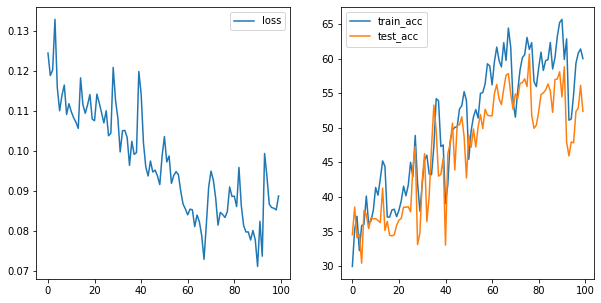

In [39]:
show_result()

RNN(
  (rnn): RNN(9, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

epoch:1000  lr:0.001  batch:919  train_acc:38.62%  test_acc:38.31%


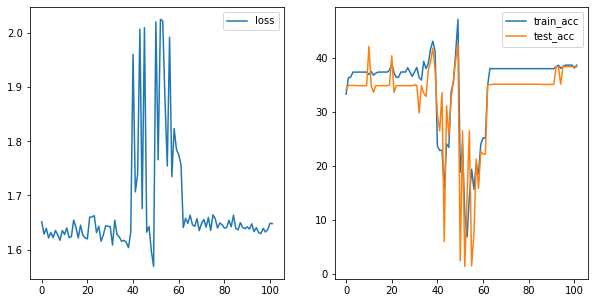

배치정규화


In [58]:
show_result()

RNN(
  (rnn): LSTM(9, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

epoch:1000  lr:0.01  batch:919  train_acc:96.45%  test_acc:89.58%


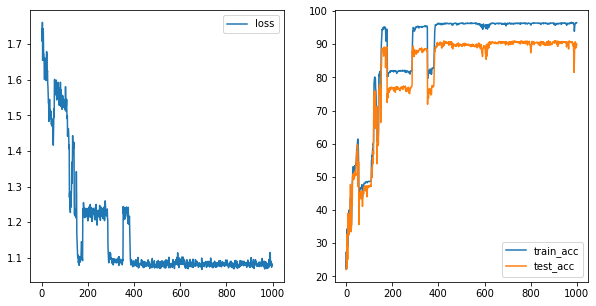

In [28]:
show_result()

RNN(
  (rnn): LSTM(9, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)

epoch:1000  lr:0.005  batch:919  train_acc:95.78%  test_acc:90.30%


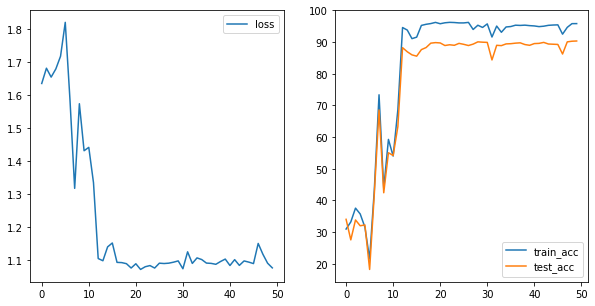

In [77]:
show_result()

RNN(
  (rnn): GRU(9, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)

epoch:1000  lr:0.005  batch:919  train_acc:96.78%  test_acc:92.23%


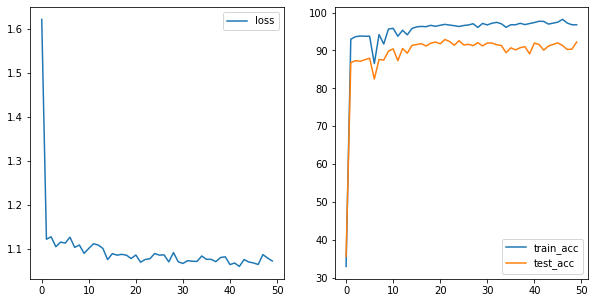

GRU사용


In [85]:
show_result()
print("GRU사용")

RNN(
  (rnn): LSTM(9, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)

epoch:1000  lr:0.005  batch:919  train_acc:93.93%  test_acc:86.02%


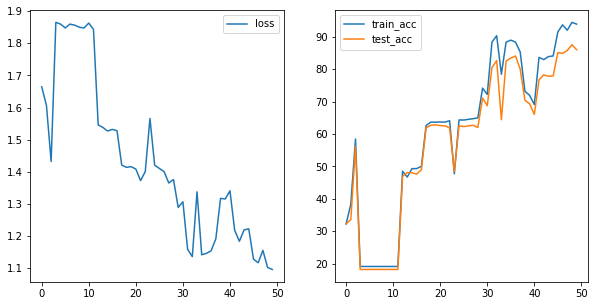

LSTM 128hidden


In [91]:
show_result()
print("LSTM 128hidden")

RNN(
  (rnn): LSTM(9, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

epoch:1000  lr:0.01  batch:919  train_acc:95.73%  test_acc:89.45%


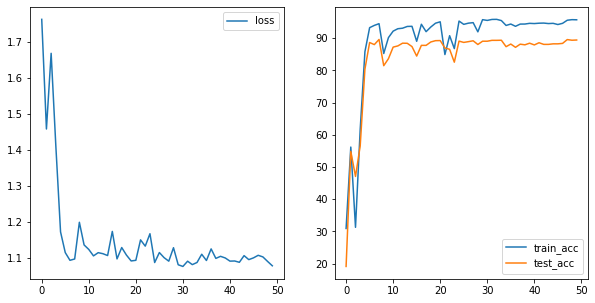

LSTM 128hidden + lr 증가


In [97]:
show_result()
print("LSTM 128hidden + lr 증가")

RNN(
  (rnn): LSTM(9, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

epoch:1000  lr:0.01  batch:919  train_acc:96.21%  test_acc:90.30%


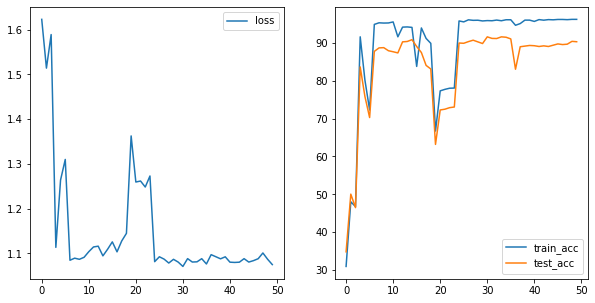

In [102]:
show_result()

RNN(
  (rnn): LSTM(9, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

epoch:1000  lr:0.01  batch:919  train_acc:97.28%  test_acc:91.48%


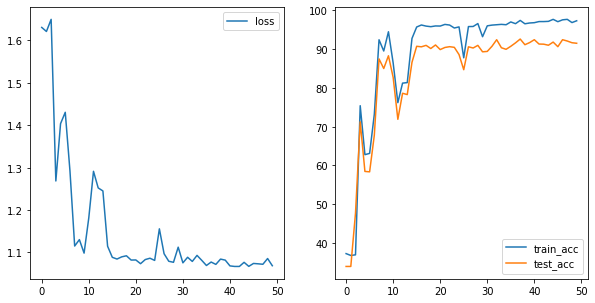

In [112]:
show_result()

RNN(
  (rnn): GRU(9, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

epoch:1000  lr:0.01  batch:919  train_acc:96.78%  test_acc:89.89%


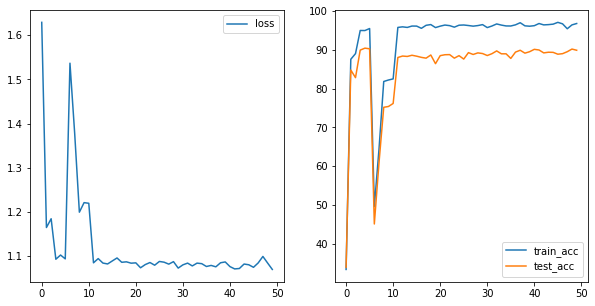

GRU 128hidden + 2layer + lr 증가


In [118]:
show_result()
print("GRU 128hidden + 2layer + lr 증가")

RNN(
  (rnn): GRU(9, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

epoch:1000  lr:0.01  batch:919  train_acc:77.57%  test_acc:70.11%


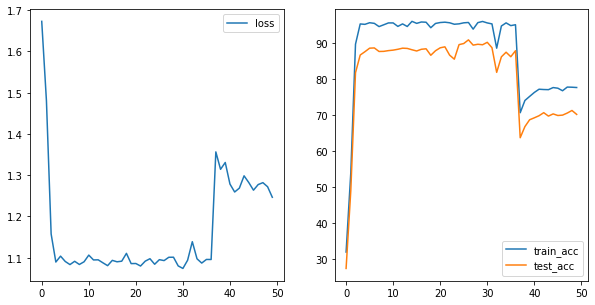

LSTM 128hidden + 4layer + lr 증가


In [128]:
show_result()
print("GRU 128hidden + 4layer + lr 증가")

RNN(
  (rnn): LSTM(9, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

epoch:1000  lr:0.01  batch:919  train_acc:76.97%  test_acc:66.17%


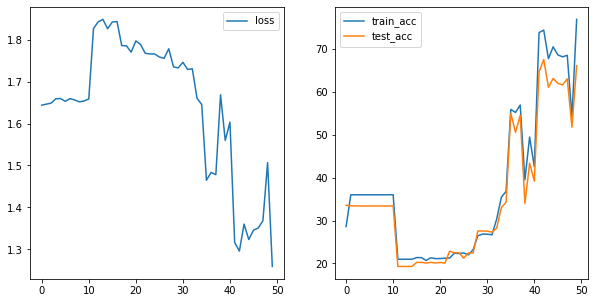

LSTM 128hidden + 4layer + hidden 64로 감소


In [136]:
show_result()
print("LSTM + 4layer + hidden 64로 감소")

RNN(
  (rnn): LSTM(9, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

epoch:1000  lr:0.01  batch:919  train_acc:95.82%  test_acc:88.60%


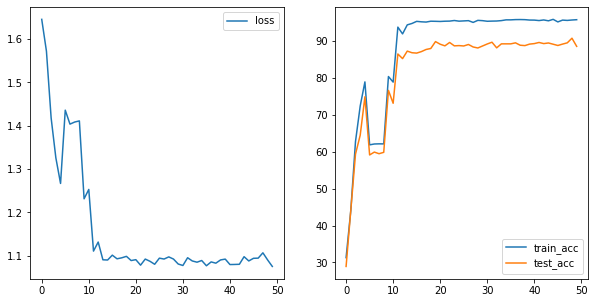

LSTM + 2layer + hidden 64로 감소


In [141]:
show_result()
print("LSTM + 2layer + hidden 64로 감소")

RNN(
  (rnn): LSTM(9, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

epoch:1000  lr:0.001  batch:919  train_acc:77.76%  test_acc:73.91%


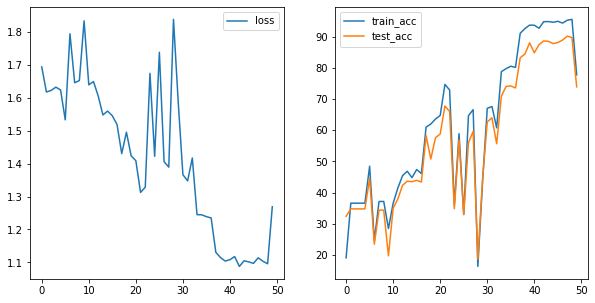

LSTM + 4layer + hidden 256 증가


In [41]:
show_result()
print("LSTM + 4layer + hidden 256 증가")

In [ ]:
show_result()
print("LSTM + 2layer + hidden 256 증가")

In [ ]:
show_result()
print("LSTM + 1layer + hidden 512 증가")

In [ ]:
show_result()
print("LSTM + 2layer + hidden 512 증가")

In [ ]:
show_result()
print("LSTM + 4layer + hidden 512 증가")